In [1]:
LENGTH = 145
BATCH = 128
from genome import Genome

In [2]:
genome = Genome('../snps/hg19.fa')

243573 243573
(156234, 4096) (156234,)
SpearmanrResult(correlation=0.32180935561878599, pvalue=0.0)
(0.36945145850910199, 0.0)


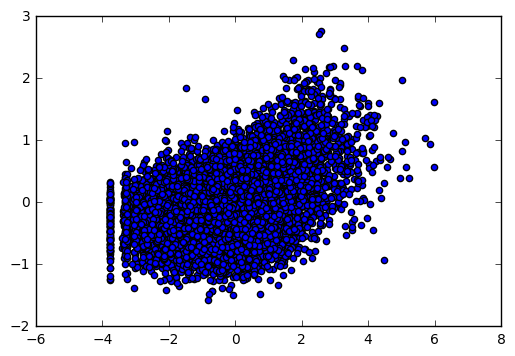

In [3]:
from kmer_model import kmer_model, kmerize, seqs_to_matrix
model = kmer_model('../enhancer_data/kellis/standard/HepG2_ScaleUpDesign1_SV40P.fa',
                   '../enhancer_activities/kellis_HepG2_ScaleUpDesign1_SV40P.activities')

In [4]:
def predict(seqs):
    seqs = kmerize(seqs_to_matrix(seqs), 6)
    return list(model.predict(seqs))

In [5]:
def score_batch(batch):
    # Construct seqs, fequencies
    ref_seqs, alt_seqs, ref_freqs = [], [], []
    for chrom, pos, risk in batch:
        ref_seqs += [genome.swapNs(
            genome.get_snv_seq(chrom, int(pos),   '', LENGTH))]
        alt_seqs += [genome.swapNs(
            genome.get_snv_seq(chrom, int(pos), risk, LENGTH))]
        if not ref_seqs[-1]:
            ref_seqs = ref_seqs[:-1]
            alt_seqs = alt_seqs[:-1]
    # Run model
    ref_preds = predict(ref_seqs)
    alt_preds = predict(alt_seqs)
    return ref_preds, alt_preds

In [6]:
gwas = '../snps/gwas_catalog_v1.0-associations_e87_r2017-03-20.tsv'
ref_preds = []
alt_preds = []
invalid = 0
with open(gwas) as fp:
    batch = []
    print fp.readline()
    for line in fp:
        chrom, pos = line.split('\t')[11:13]
        if not pos or len(pos.split(';')) != 1 or 'x' in pos:
            invalid += 1
            continue
        risk_allele = line.split('\t')[20].split('-')[-1]
        if risk_allele not in ['A', 'C', 'G', 'T', '?']:
            invalid += 1
            continue
        batch += [('chr' + chrom, pos, risk_allele)]
        if len(batch) ==  BATCH:
            rp, ap = score_batch(batch)
            ref_preds += rp
            alt_preds += ap
            batch = []
print invalid

DATE ADDED TO CATALOG	PUBMEDID	FIRST AUTHOR	DATE	JOURNAL	LINK	STUDY	DISEASE/TRAIT	INITIAL SAMPLE SIZE	REPLICATION SAMPLE SIZE	REGION	CHR_ID	CHR_POS	REPORTED GENE(S)	MAPPED_GENE	UPSTREAM_GENE_ID	DOWNSTREAM_GENE_ID	SNP_GENE_IDS	UPSTREAM_GENE_DISTANCE	DOWNSTREAM_GENE_DISTANCE	STRONGEST SNP-RISK ALLELE	SNPS	MERGED	SNP_ID_CURRENT	CONTEXT	INTERGENIC	RISK ALLELE FREQUENCY	P-VALUE	PVALUE_MLOG	P-VALUE (TEXT)	OR or BETA	95% CI (TEXT)	PLATFORM [SNPS PASSING QC]	CNV

1309


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
%matplotlib inline

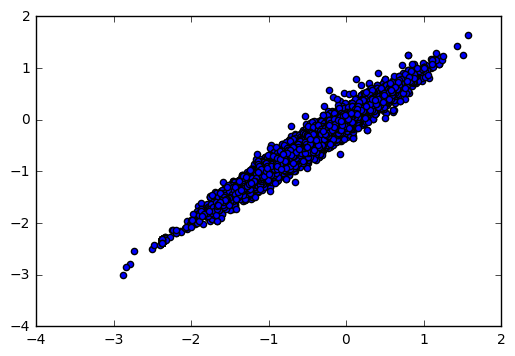

Ttest_relResult(statistic=-5.4908397773010851, pvalue=4.0278294520148487e-08)
Ttest_indResult(statistic=-0.70350478698615104, pvalue=0.48174354807916886)


In [8]:
plt.scatter(ref_preds, alt_preds)
plt.show()
print stats.ttest_rel(ref_preds, alt_preds)
print stats.ttest_ind(ref_preds, alt_preds)

0.0 -0.00259783231719


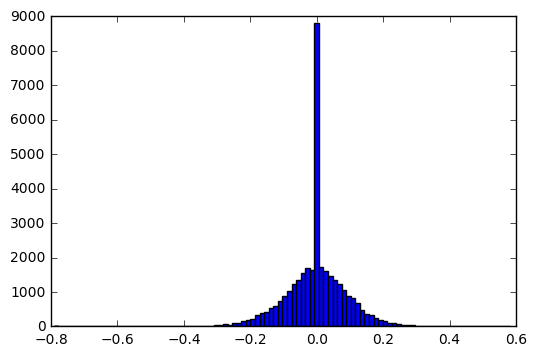

In [9]:
diff = np.array(ref_preds) - np.array(alt_preds)
print np.median(diff), np.mean(diff)
plt.hist(diff, bins = 100)
plt.show()

Ttest_indResult(statistic=-0.70350478698615104, pvalue=0.48174354807916886)
-0.446658114187 -0.444060281869


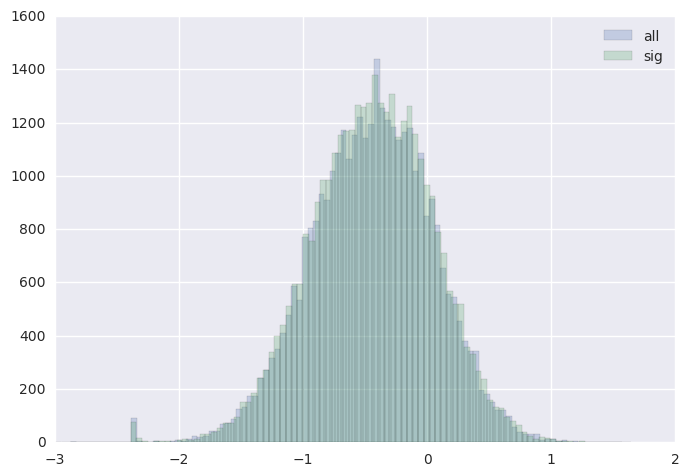

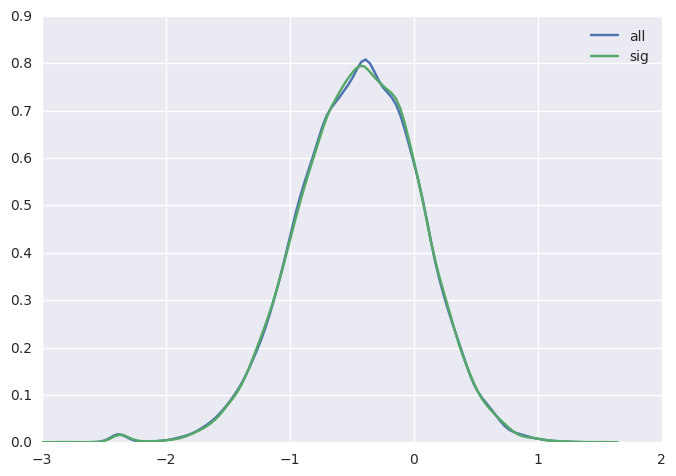

In [10]:
import seaborn as sns
a = np.array(ref_preds)
s = np.array(alt_preds)
print stats.ttest_ind(a, s)
print a.mean(), s.mean()

plt.hist(a, bins = 100, alpha = .25, label = 'all')
plt.hist(s, bins = 100, alpha = .25, label = 'sig')

plt.legend()
plt.show()
sns.kdeplot(a, cut = 0, label = 'all')
sns.kdeplot(s, cut = 0, label = 'sig')
plt.show()

In [11]:
batch_count = 0
all_ref_preds, all_alt_preds = [], []
with open('../snps/valid_snp.txt') as fp:
    batch = []
    for line in fp:
        chrom, start, end, strand, alleleFreqs, diff = line.strip().split('\t')
        batch += [(chrom, start, diff.split('/')[1])]
        if len(batch) == BATCH:
            ap, rp = score_batch(batch)
            all_ref_preds += rp
            all_alt_preds += ap
            batch = []
            batch_count += 1
            if batch_count > 1000:
                break

Ttest_indResult(statistic=153.17683241071859, pvalue=0.0)
-0.0356908148474 -0.446658114187


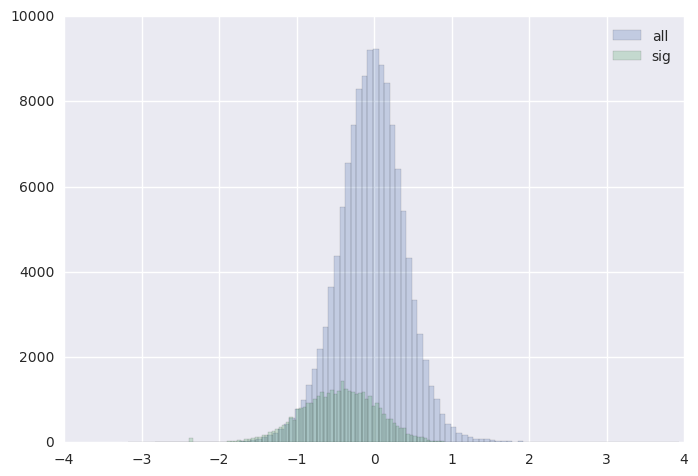

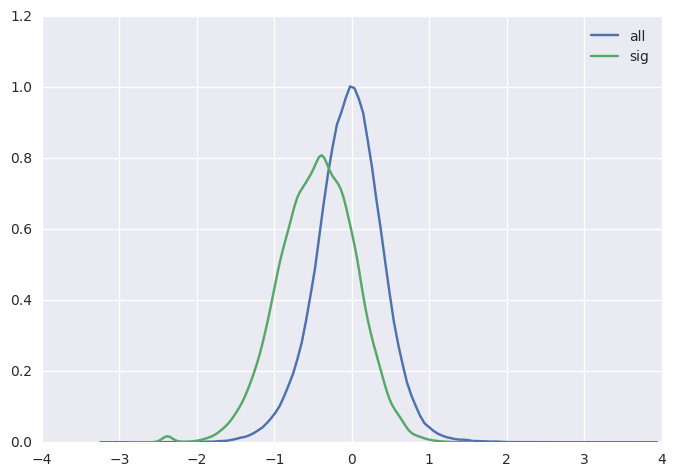

In [12]:
a = np.array(all_ref_preds)
s = np.array(ref_preds)
print stats.ttest_ind(a, s)
print a.mean(), s.mean()

plt.hist(a, bins = 100, alpha = .25, label = 'all')
plt.hist(s, bins = 100, alpha = .25, label = 'sig')

plt.legend()
plt.show()
sns.kdeplot(a, cut = 0, label = 'all')
sns.kdeplot(s, cut = 0, label = 'sig')
plt.show()

Ttest_indResult(statistic=3.4726474186831267, pvalue=0.00051548514806038035)
-0.000957407055757 -0.00259783231719


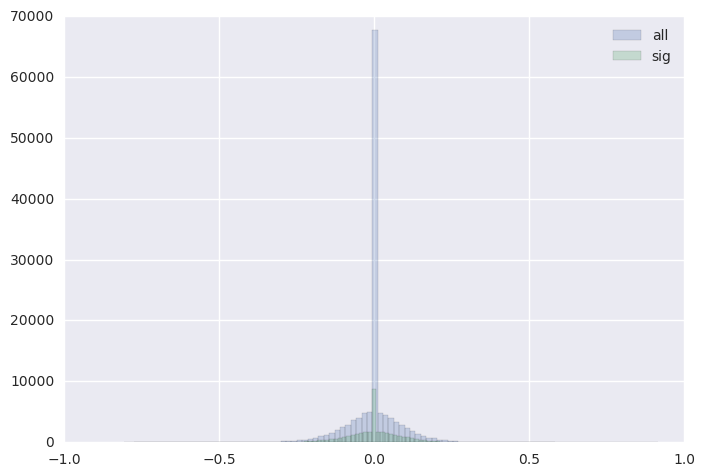

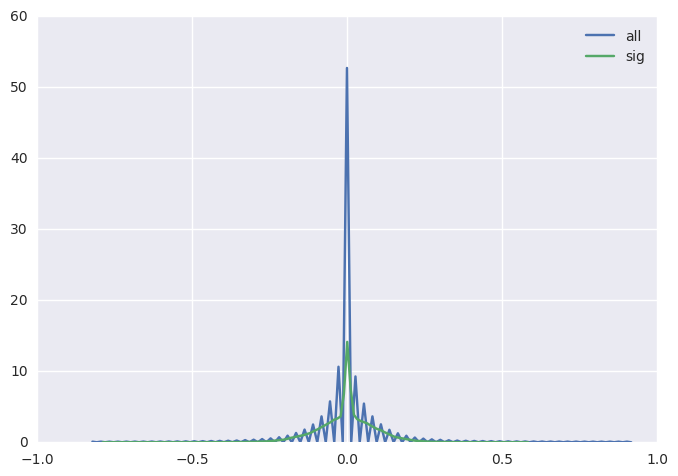

In [13]:
a = np.array(np.array(all_ref_preds) - np.array(all_alt_preds))
s = np.array(np.array(ref_preds) - np.array(alt_preds))
print stats.ttest_ind(a, s)
print a.mean(), s.mean()

plt.hist(a, bins = 100, alpha = .25, label = 'all')
plt.hist(s, bins = 100, alpha = .25, label = 'sig')

plt.legend()
plt.show()
sns.kdeplot(a, cut = 0, label = 'all')
sns.kdeplot(s, cut = 0, label = 'sig')
plt.show()